In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from netCDF4 import Dataset
from wrf import getvar, to_np, get_cartopy, cartopy_xlim, cartopy_ylim, latlon_coords, ALL_TIMES, interp1d
import wrf
import metpy.calc as mpcalc
from metpy.units import units

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime, timedelta

import pandas as pd

/research/modules/mpich/miniconda3/lib/python3.9/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
obs_path = "./Deployments/NorthDakota_Annular_Eclipse/Lufft/CR300Series_LufftData.dat"

obs = pd.read_csv(obs_path,header=1)
obs.drop(index=[0,1],inplace=True)
obs.TIMESTAMP = pd.to_datetime(obs.TIMESTAMP)
dts = pd.to_datetime(obs.TIMESTAMP.values)
dts = dts - timedelta(hours=6)


obs = obs.set_index(dts)
obs.drop(columns=["TIMESTAMP","RECORD","BattV","PTemp_C"],inplace=True)
obs_dir = np.array(obs.WindDirect_deg.values).astype(float)*units('degree')
obs_spd = np.array(obs.WindSpeed_ms.values).astype(float)*units('m/s')

obs_u,obs_v = mpcalc.wind_components(obs_spd,obs_dir)
obs['U_ms']=obs_u
obs['V_ms']=obs_v

obs = obs.astype('float')
obs_max = obs.resample('5min').max()
obs = obs.resample('5min').mean()

obs_dir = mpcalc.wind_direction(obs.U_ms.values*units('m/s'),obs.V_ms.values*units('m/s'))
obs_spd = mpcalc.wind_speed(obs.U_ms.values*units('m/s'),obs.V_ms.values*units('m/s'))

obs_irr = np.array(obs_max.Solar_W_m2.values).astype(float)*units('W/m^2')

obs_dir = obs_dir.magnitude.astype(float)
obs_spd = obs_spd.magnitude.astype(float)

dts = pd.to_datetime(obs.index.values)

obs_hours = np.array([((i.day-14)*24)+(i.hour)+(i.minute/60) for i in dts])



473
473


In [3]:
d01_fname = "wrfout_d01_2023-10-11_00:00:00"
d02_fname = "wrfout_d02_2023-10-11_00:00:00"
d03_fname = "wrfout_d03_2023-10-11_00:00:00"

eclipse_dir = "./eclipse"
no_eclipse_dir = "./no_eclipse"

nc_eclipse_d01 = Dataset(eclipse_dir+"/"+d01_fname)
nc_eclipse_d02 = Dataset(eclipse_dir+"/"+d02_fname)
nc_eclipse_d03 = Dataset(eclipse_dir+"/"+d03_fname)

nc_no_eclipse_d01 = Dataset(no_eclipse_dir+"/"+d01_fname)
nc_no_eclipse_d02 = Dataset(no_eclipse_dir+"/"+d02_fname)
nc_no_eclipse_d03 = Dataset(no_eclipse_dir+"/"+d03_fname)

In [4]:
u_eclipse_d03 = getvar(nc_eclipse_d03,"U10",timeidx=ALL_TIMES)
v_eclipse_d03 = getvar(nc_eclipse_d03,"V10",timeidx=ALL_TIMES)

u_eclipse_d03 = wrf.destagger(wrf.destagger(u_eclipse_d03,1),2)
v_eclipse_d03 = wrf.destagger(wrf.destagger(v_eclipse_d03,1),2)

hgt_d03 = getvar(nc_eclipse_d03,"HGT")
times = getvar(nc_eclipse_d03,"Times",timeidx=ALL_TIMES)

irr_eclipse_d03 = getvar(nc_eclipse_d03,"SWDOWN",timeidx=ALL_TIMES)
irr_no_eclipse_d03 = getvar(nc_no_eclipse_d03,"SWDOWN",timeidx=ALL_TIMES)

u_no_eclipse_d03 = getvar(nc_no_eclipse_d03,"U10",timeidx=ALL_TIMES)
v_no_eclipse_d03 = getvar(nc_no_eclipse_d03,"V10",timeidx=ALL_TIMES)

u_no_eclipse_d03 = wrf.destagger(wrf.destagger(u_no_eclipse_d03,1),2)
v_no_eclipse_d03 = wrf.destagger(wrf.destagger(v_no_eclipse_d03,1),2)

lats, lons = latlon_coords(hgt_d03)
cart_proj = get_cartopy(hgt_d03)

dts = pd.to_datetime((times.values),format="%Y-%m-%dT%H:%M:%S.%f")
dts = dts - timedelta(hours=6)
hours = (((dts.day-14)*24)+dts.hour+dts.minute/60)

In [5]:
#bilinear interp to location
pccc_lon = -108.43834
pccc_lat = 37.35477

bl_index = np.where((lons.values<=pccc_lon) & (lats.values<=pccc_lat))
bl_i = bl_index[0][-1]
bl_j = bl_index[1][-1]

frac_ind_i = (pccc_lat - lats.values[bl_i,bl_j]) / (lats.values[bl_i+1,bl_j+1] - lats.values[bl_i,bl_j])
frac_ind_j = (pccc_lon - lons.values[bl_i,bl_j]) / (lons.values[bl_i+1,bl_j+1] - lons.values[bl_i,bl_j])

u_eclipse_pccc = np.empty(len(u_eclipse_d03))
v_eclipse_pccc = np.empty(len(v_eclipse_d03))
irr_eclipse_pccc = np.empty(len(v_eclipse_d03))

u_no_eclipse_pccc = np.empty(len(u_no_eclipse_d03))
v_no_eclipse_pccc = np.empty(len(v_no_eclipse_d03))
irr_no_eclipse_pccc = np.empty(len(v_no_eclipse_d03))

for i in range(len(u_eclipse_pccc)):
    x_mat = np.matrix([1-frac_ind_i, frac_ind_i])
    y_mat = np.matrix([[1-frac_ind_j],[frac_ind_j]])
    
    #do x-direction
    f00 = u_eclipse_d03[i][bl_i,bl_j]
    f01 = u_eclipse_d03[i][bl_i,bl_j+1]
    f10 = u_eclipse_d03[i][bl_i+1,bl_j]
    f11 = u_eclipse_d03[i][bl_i+1,bl_j+1]
    f_mat = np.matrix([[f00, f01], [f10, f11]])
    u_eclipse_pccc[i] = (x_mat*f_mat*y_mat).item()
    
    f00 = u_no_eclipse_d03[i][bl_i,bl_j]
    f01 = u_no_eclipse_d03[i][bl_i,bl_j+1]
    f10 = u_no_eclipse_d03[i][bl_i+1,bl_j]
    f11 = u_no_eclipse_d03[i][bl_i+1,bl_j+1]
    f_mat = np.matrix([[f00, f01], [f10, f11]])
    u_no_eclipse_pccc[i] = (x_mat*f_mat*y_mat).item()
    
    #do y-direction
    f00 = v_eclipse_d03[i][bl_i,bl_j]
    f01 = v_eclipse_d03[i][bl_i,bl_j+1]
    f10 = v_eclipse_d03[i][bl_i+1,bl_j]
    f11 = v_eclipse_d03[i][bl_i+1,bl_j+1]
    f_mat = np.matrix([[f00, f01], [f10, f11]])
    v_eclipse_pccc[i] = (x_mat*f_mat*y_mat).item()
    
    f00 = v_no_eclipse_d03[i][bl_i,bl_j]
    f01 = v_no_eclipse_d03[i][bl_i,bl_j+1]
    f10 = v_no_eclipse_d03[i][bl_i+1,bl_j]
    f11 = v_no_eclipse_d03[i][bl_i+1,bl_j+1]
    f_mat = np.matrix([[f00, f01], [f10, f11]])
    v_no_eclipse_pccc[i] = (x_mat*f_mat*y_mat).item()
    
    #do solar irrad
    f00 = irr_eclipse_d03[i][bl_i,bl_j]
    f01 = irr_eclipse_d03[i][bl_i,bl_j+1]
    f10 = irr_eclipse_d03[i][bl_i+1,bl_j]
    f11 = irr_eclipse_d03[i][bl_i+1,bl_j+1]
    f_mat = np.matrix([[f00, f01], [f10, f11]])
    irr_eclipse_pccc[i] = (x_mat*f_mat*y_mat).item()
    
    f00 = irr_no_eclipse_d03[i][bl_i,bl_j]
    f01 = irr_no_eclipse_d03[i][bl_i,bl_j+1]
    f10 = irr_no_eclipse_d03[i][bl_i+1,bl_j]
    f11 = irr_no_eclipse_d03[i][bl_i+1,bl_j+1]
    f_mat = np.matrix([[f00, f01], [f10, f11]])
    irr_no_eclipse_pccc[i] = (x_mat*f_mat*y_mat).item()

spd_eclipse_pccc = (u_eclipse_pccc**2 + v_eclipse_pccc**2)**(1/2)
spd_no_eclipse_pccc = (u_no_eclipse_pccc**2 + v_no_eclipse_pccc**2)**(1/2)

dir_eclipse_pccc = mpcalc.wind_direction(u_eclipse_pccc*units('m/s'),v_eclipse_pccc*units('m/s'))
dir_no_eclipse_pccc = mpcalc.wind_direction(u_no_eclipse_pccc*units('m/s'),v_no_eclipse_pccc*units('m/s'))    

No Eclipse Wind Shift @ 11:10 Local Time
Eclipse Wind Shift @ 12:20 Local Time
Observed Wind Shift @ 12:20 Local Time


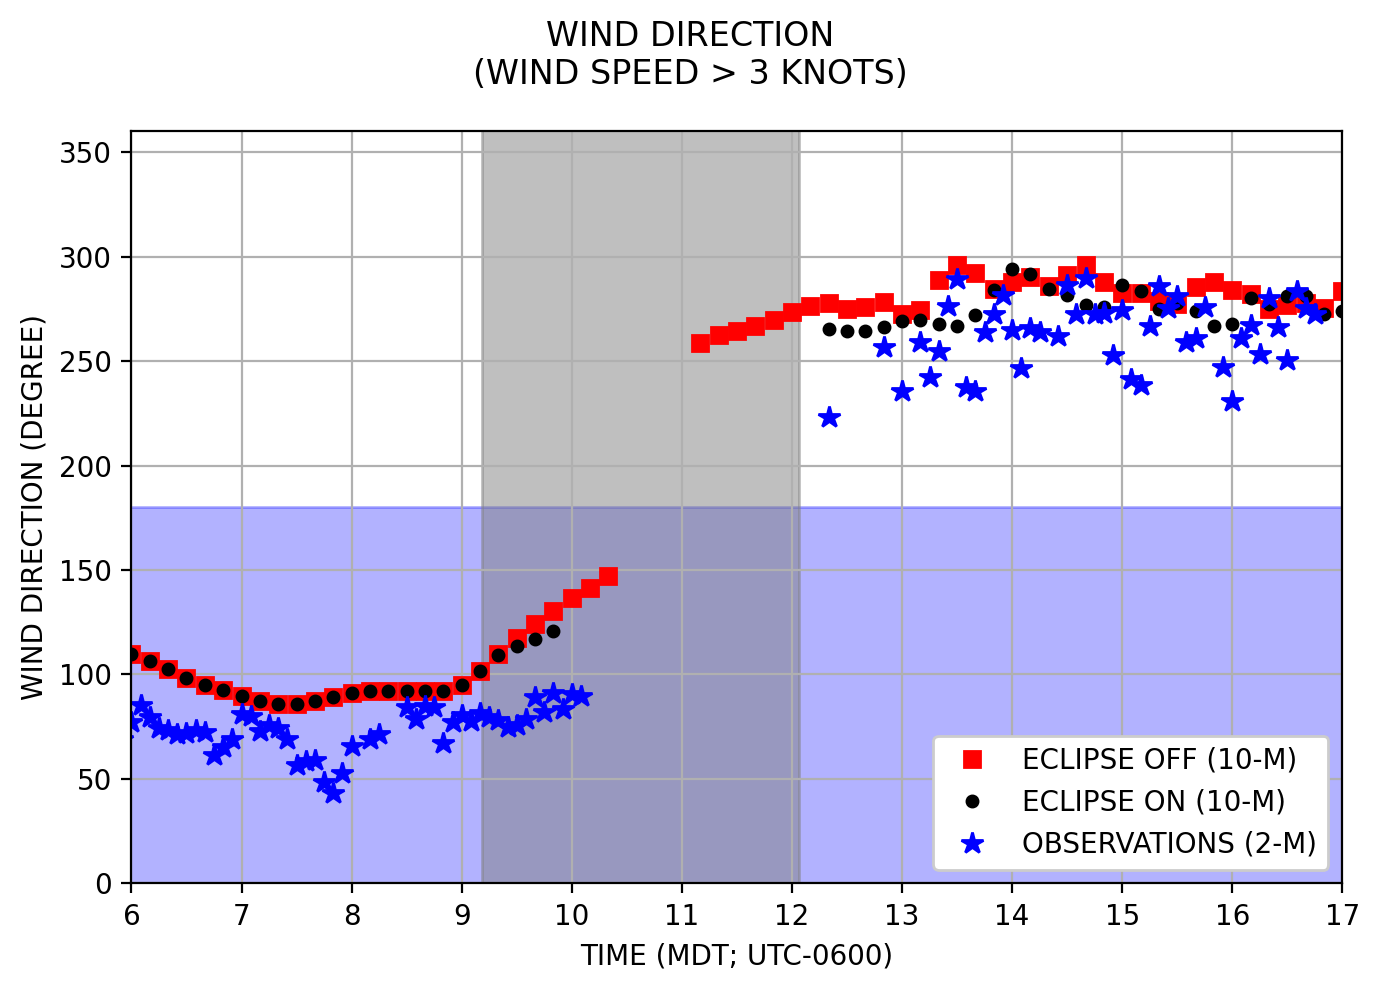

In [6]:
minimum=3
fig = plt.figure(figsize=(7,5),dpi=200)
mask_eclipse = np.where(spd_eclipse_pccc*1.94384<minimum)
mask_abv_eclipse = np.where(spd_eclipse_pccc*1.94384>=minimum)
mask_no_eclipse = np.where(spd_no_eclipse_pccc*1.94384<minimum)
mask_abv_no_eclipse = np.where(spd_no_eclipse_pccc*1.94384>=minimum)
mask_obs = np.where(obs_spd*1.94384<minimum)
mask_abv_obs = np.where(obs_spd*1.94384>=minimum)
dir_eclipse_pccc_slow = np.copy(dir_eclipse_pccc)
dir_eclipse_pccc[mask_eclipse] = np.nan
dir_eclipse_pccc_slow[mask_abv_eclipse] = np.nan
dir_no_eclipse_pccc_slow = np.copy(dir_no_eclipse_pccc)
dir_no_eclipse_pccc[mask_no_eclipse] = np.nan
dir_no_eclipse_pccc_slow[mask_abv_no_eclipse] = np.nan
dir_obs_masked = np.copy(obs_dir)
dir_obs_masked[mask_obs] = np.nan
dir_obs_slow = np.copy(obs_dir)
dir_obs_slow[mask_abv_obs] = np.nan

first_ind = np.where(dir_no_eclipse_pccc[468:650].magnitude>180)[0][0]
first_time = hours[468+first_ind]
print("No Eclipse Wind Shift @ %02i:%02i Local Time"%(int(first_time),round(60*(first_time-int(first_time)))))
first_ind = np.where(dir_eclipse_pccc[468:650].magnitude>180)[0][0]
first_time = hours[468+first_ind]
print("Eclipse Wind Shift @ %02i:%02i Local Time"%(int(first_time),round(60*(first_time-int(first_time)))))
first_ind = np.where((obs_hours>0) & (dir_obs_masked>180))[0][0]
first_time = obs_hours[first_ind]
print("Observed Wind Shift @ %02i:%02i Local Time"%(int(first_time),round(60*(first_time-int(first_time)))))


ax=plt.subplot(111)
ax.plot(hours[468:650],dir_no_eclipse_pccc[468:650],'s',markeredgecolor='r',markerfacecolor='r',markersize=6,label='ECLIPSE OFF (10-M)')
ax.plot(hours[468:650],dir_eclipse_pccc[468:650],'.',markeredgecolor='k',markerfacecolor='k',markersize=8,label='ECLIPSE ON (10-M)')
ax.plot(obs_hours,dir_obs_masked,'*',markeredgecolor='b',markerfacecolor='b',markersize=8,label=f'OBSERVATIONS (2-M)')
plt.legend(facecolor='w',framealpha=1,loc="lower right")
ax.fill_between(hours[468:650],0,180,color='b',alpha=0.3)
ax.axvspan(9.18,12.06,0,360,color='gray',alpha=0.5)
plt.ylim(0,360)
plt.xlim(6,17)
ax.set_xticks(range(6,18))
plt.grid()
fig.suptitle(f'WIND DIRECTION\n(WIND SPEED > {minimum} KNOTS)')
plt.ylabel('WIND DIRECTION (DEGREE)')
plt.xlabel('TIME (MDT; UTC-0600)')
fig.tight_layout()
plt.savefig("wind_dir_10m.png",bbox_inches='tight')

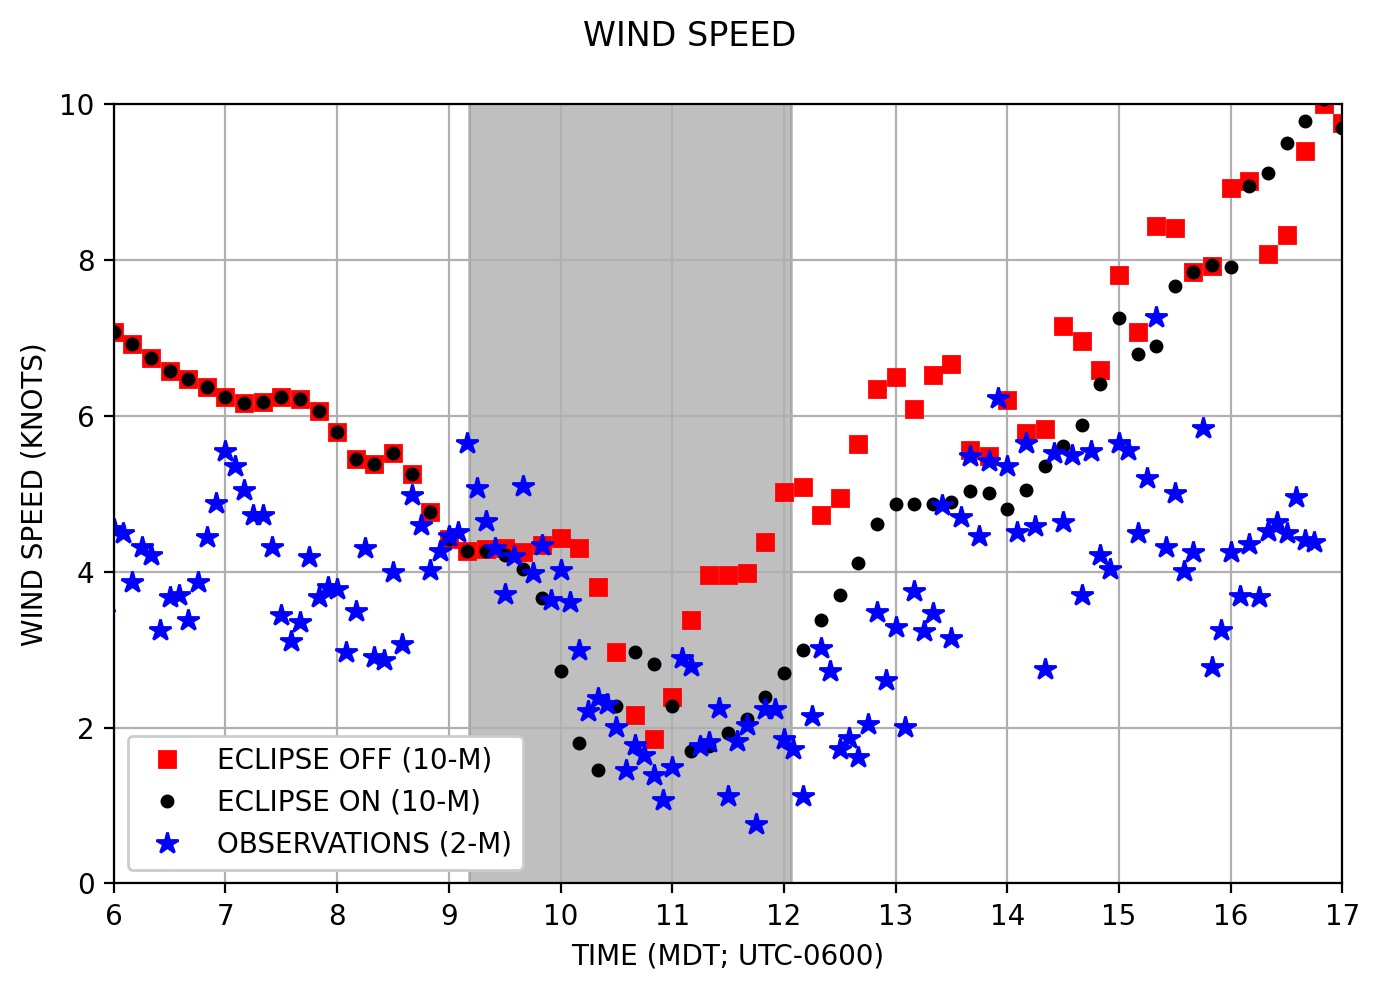

In [7]:
fig = plt.figure(figsize=(7,5),dpi=200)
ws_eclipse_pccc = np.copy(spd_eclipse_pccc)*1.94384
ws_no_eclipse_pccc = np.copy(spd_no_eclipse_pccc)*1.94384
ws_obs = np.copy(obs_spd)*1.94384

ax=plt.subplot(111)
ax.plot(hours[468:650],ws_no_eclipse_pccc[468:650],'s',markeredgecolor='r',markerfacecolor='r',markersize=6,label='ECLIPSE OFF (10-M)')
ax.plot(hours[468:650],ws_eclipse_pccc[468:650],'.',markeredgecolor='k',markerfacecolor='k',markersize=8,label='ECLIPSE ON (10-M)')
ax.plot(obs_hours,ws_obs,'*',markeredgecolor='b',markerfacecolor='b',markersize=8,label=f'OBSERVATIONS (2-M)')
plt.legend(facecolor='w',framealpha=1,loc="lower left")
ax.axvspan(9.18,12.06,0,360,color='gray',alpha=0.5)
plt.ylim(0,10)
plt.xlim(6,17)
ax.set_xticks(range(6,18))
plt.grid()
fig.suptitle(f'WIND SPEED')
plt.ylabel('WIND SPEED (KNOTS)')
plt.xlabel('TIME (MDT; UTC-0600)')
fig.tight_layout()
plt.savefig("wind_spd_10m.png",bbox_inches='tight')

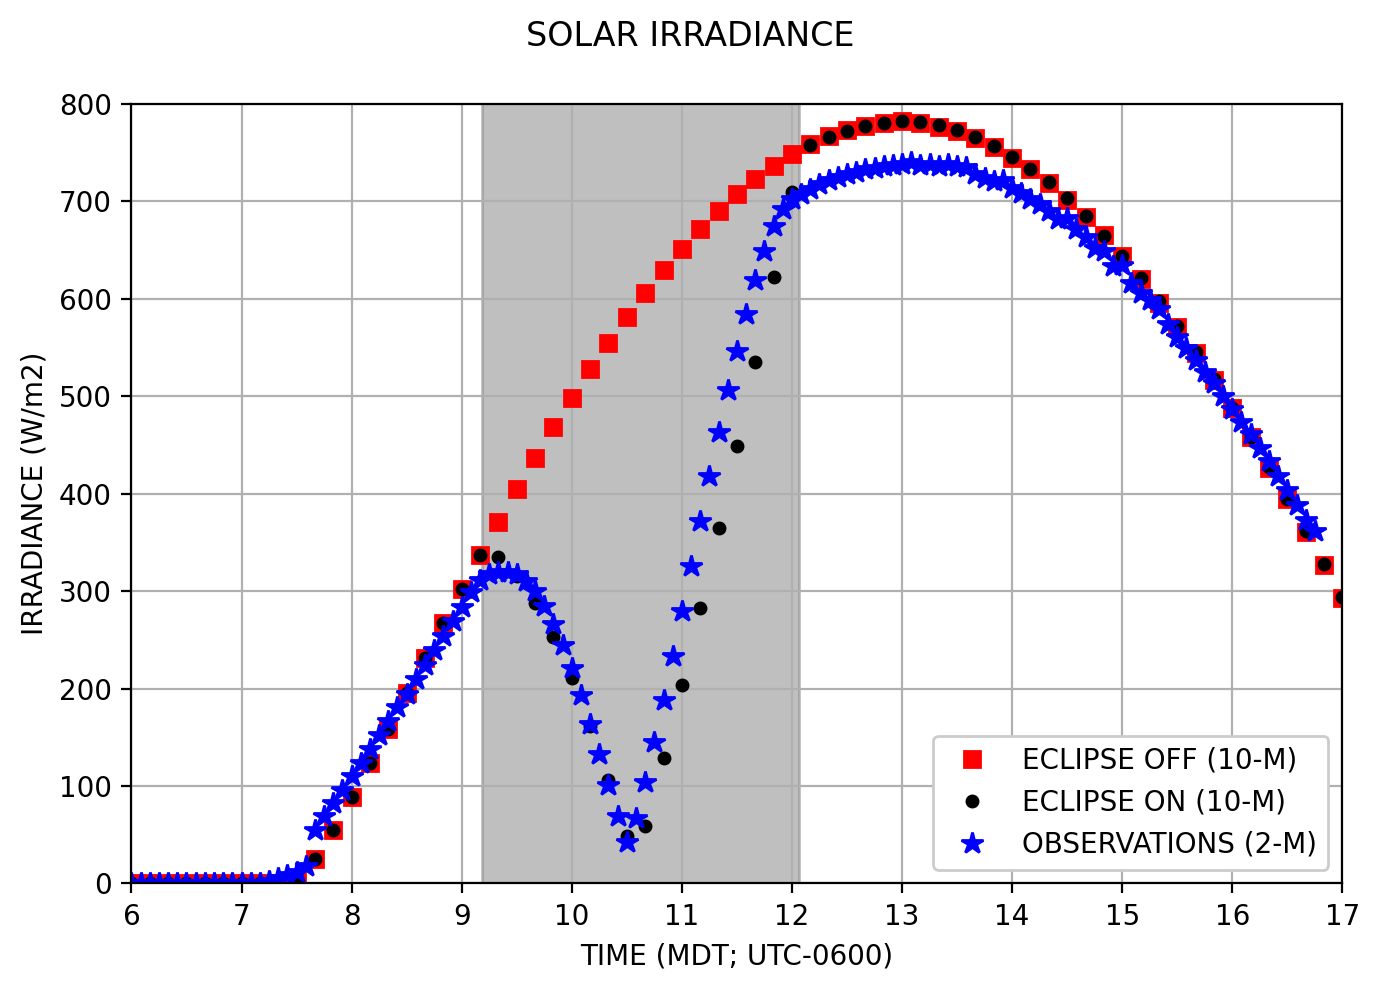

In [8]:
fig = plt.figure(figsize=(7,5),dpi=200)

ax=plt.subplot(111)
ax.plot(hours[468:650],irr_no_eclipse_pccc[468:650],'s',markeredgecolor='r',markerfacecolor='r',markersize=6,label='ECLIPSE OFF (10-M)')
ax.plot(hours[468:650],irr_eclipse_pccc[468:650],'.',markeredgecolor='k',markerfacecolor='k',markersize=8,label='ECLIPSE ON (10-M)')
ax.plot(obs_hours,obs_irr,'*',markeredgecolor='b',markerfacecolor='b',markersize=8,label=f'OBSERVATIONS (2-M)')
plt.legend(facecolor='w',framealpha=1,loc="lower right")
ax.axvspan(9.18,12.06,0,360,color='gray',alpha=0.5)
plt.ylim(0,800)
plt.xlim(6,17)
ax.set_xticks(range(6,18))
plt.grid()
fig.suptitle(f'SOLAR IRRADIANCE')
plt.ylabel('IRRADIANCE (W/m2)')
plt.xlabel('TIME (MDT; UTC-0600)')
fig.tight_layout()
plt.savefig("solar_irrad.png",bbox_inches='tight')

/tmp/ipykernel_1525465/3692816068.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs_irr_wrf_time[i] = obs_irr[ind].magnitude
/tmp/ipykernel_1525465/3692816068.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if ind and ind<len(obs_irr):
/tmp/ipykernel_1525465/3692816068.py:11: RuntimeWarning: divide by zero encountered in divide
  per_diff = (obs_irr_wrf_time - irr_eclipse_pccc[468:650]) / obs_irr_wrf_time
/tmp/ipykernel_1525465/3692816068.py:11: RuntimeWarning: invalid value encountered in divide
  per_diff = (obs_irr_wrf_time - irr_eclipse_pccc[468:650]) / obs_irr_wrf_time


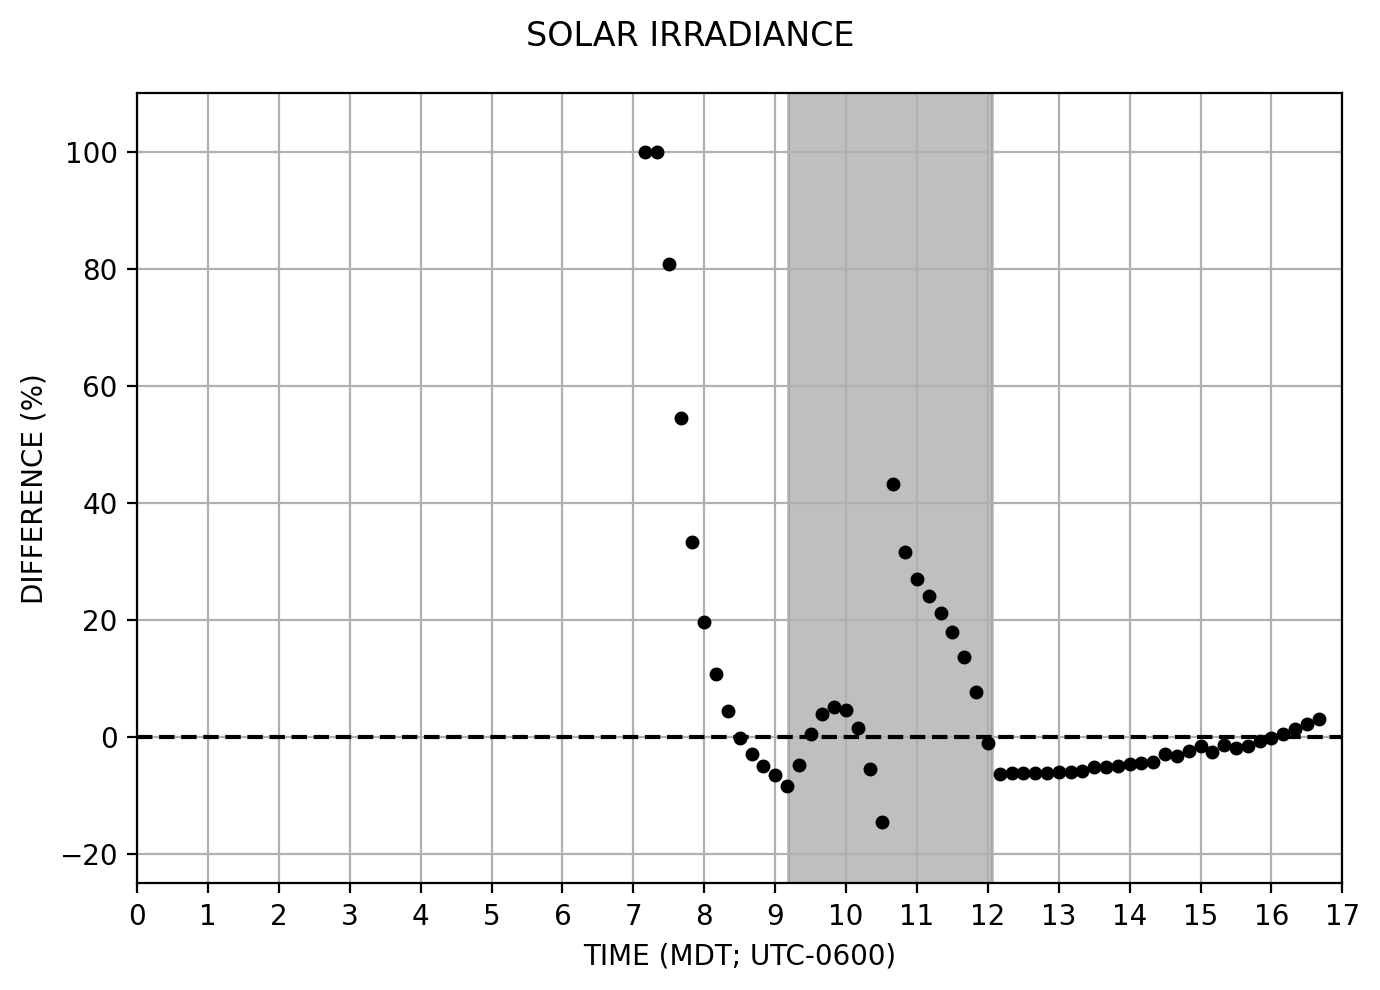

In [9]:
fig = plt.figure(figsize=(7,5),dpi=200)

obs_irr_wrf_time = np.zeros(len(hours[468:650]))

for i in range(len(obs_irr_wrf_time)):
    ind = np.where(obs_hours==hours[468:650][i])[0]
    if ind and ind<len(obs_irr):
        obs_irr_wrf_time[i] = obs_irr[ind].magnitude
        
   
per_diff = (obs_irr_wrf_time - irr_eclipse_pccc[468:650]) / obs_irr_wrf_time
diff = obs_irr_wrf_time - irr_eclipse_pccc[468:650]

    
ax=plt.subplot(111)

ax.plot([0,23],[0,0],'--k')
ax.plot(hours[468:650],100*per_diff,'.',markeredgecolor='k',markerfacecolor='k',markersize=8)

ax.axvspan(9.18,12.06,0,360,color='gray',alpha=0.5)
plt.ylim(-25,110)
plt.xlim(0,17)
ax.set_xticks(range(18))
plt.grid()
fig.suptitle(f'SOLAR IRRADIANCE')
plt.ylabel('DIFFERENCE (%)')
plt.xlabel('TIME (MDT; UTC-0600)')
fig.tight_layout()
plt.savefig("solar_irrad_diff.png",bbox_inches='tight')

In [10]:
obs_asos = pd.read_csv('KCEZ_OBS.csv',header=0)
obs_asos_dir = pd.to_numeric(obs_asos['drct'], errors='coerce')
obs_asos_dir.fillna(np.nan, inplace=True)
obs_asos_spd = pd.to_numeric(obs_asos['sknt'], errors='coerce')*units('knots')
obs_asos_spd.fillna(np.nan, inplace=True)
dts_asos = pd.to_datetime(obs_asos.valid) - timedelta(hours=6)
obs_hours = np.array([((i.day-14)*24)+(i.hour)+(i.minute/60) for i in dts_asos])


(862,)


In [11]:
u_eclipse_d03 = getvar(nc_eclipse_d03,"U10",timeidx=ALL_TIMES)
v_eclipse_d03 = getvar(nc_eclipse_d03,"V10",timeidx=ALL_TIMES)

u_eclipse_d03 = wrf.destagger(wrf.destagger(u_eclipse_d03,1),2)
v_eclipse_d03 = wrf.destagger(wrf.destagger(v_eclipse_d03,1),2)

hgt_d03 = getvar(nc_eclipse_d03,"HGT")
times = getvar(nc_eclipse_d03,"Times",timeidx=ALL_TIMES)

u_no_eclipse_d03 = getvar(nc_no_eclipse_d03,"U10",timeidx=ALL_TIMES)
v_no_eclipse_d03 = getvar(nc_no_eclipse_d03,"V10",timeidx=ALL_TIMES)

u_no_eclipse_d03 = wrf.destagger(wrf.destagger(u_no_eclipse_d03,1),2)
v_no_eclipse_d03 = wrf.destagger(wrf.destagger(v_no_eclipse_d03,1),2)

lats, lons = latlon_coords(hgt_d03)
cart_proj = get_cartopy(hgt_d03)

dts = pd.to_datetime((times.values),format="%Y-%m-%dT%H:%M:%S.%f")
dts = dts - timedelta(hours=6)
hours = (((dts.day-14)*24)+dts.hour+dts.minute/60)

In [12]:
#bilinear interp to location
asos_lon = -108.62644
asos_lat = 37.30706

bl_index = np.where((lons.values<=asos_lon) & (lats.values<=asos_lat))
bl_i = bl_index[0][-1]
bl_j = bl_index[1][-1]
#i increases lat, j increases lon

frac_ind_i = (asos_lat - lats.values[bl_i,bl_j]) / (lats.values[bl_i+1,bl_j+1] - lats.values[bl_i,bl_j])
frac_ind_j = (asos_lon - lons.values[bl_i,bl_j]) / (lons.values[bl_i+1,bl_j+1] - lons.values[bl_i,bl_j])

u_eclipse_asos = np.empty(len(u_eclipse_d03))
v_eclipse_asos = np.empty(len(v_eclipse_d03))

u_no_eclipse_asos = np.empty(len(u_no_eclipse_d03))
v_no_eclipse_asos = np.empty(len(v_no_eclipse_d03))

for i in range(len(u_eclipse_asos)):
    x_mat = np.matrix([1-frac_ind_i, frac_ind_i])
    y_mat = np.matrix([[1-frac_ind_j],[frac_ind_j]])
    
    #do x-direction
    f00 = u_eclipse_d03[i][bl_i,bl_j]
    f01 = u_eclipse_d03[i][bl_i,bl_j+1]
    f10 = u_eclipse_d03[i][bl_i+1,bl_j]
    f11 = u_eclipse_d03[i][bl_i+1,bl_j+1]
    f_mat = np.matrix([[f00, f01], [f10, f11]])
    u_eclipse_asos[i] = (x_mat*f_mat*y_mat).item()
    
    f00 = u_no_eclipse_d03[i][bl_i,bl_j]
    f01 = u_no_eclipse_d03[i][bl_i,bl_j+1]
    f10 = u_no_eclipse_d03[i][bl_i+1,bl_j]
    f11 = u_no_eclipse_d03[i][bl_i+1,bl_j+1]
    f_mat = np.matrix([[f00, f01], [f10, f11]])
    u_no_eclipse_asos[i] = (x_mat*f_mat*y_mat).item()
    
    #do y-direction
    f00 = v_eclipse_d03[i][bl_i,bl_j]
    f01 = v_eclipse_d03[i][bl_i,bl_j+1]
    f10 = v_eclipse_d03[i][bl_i+1,bl_j]
    f11 = v_eclipse_d03[i][bl_i+1,bl_j+1]
    f_mat = np.matrix([[f00, f01], [f10, f11]])
    v_eclipse_asos[i] = (x_mat*f_mat*y_mat).item()
    
    f00 = v_no_eclipse_d03[i][bl_i,bl_j]
    f01 = v_no_eclipse_d03[i][bl_i,bl_j+1]
    f10 = v_no_eclipse_d03[i][bl_i+1,bl_j]
    f11 = v_no_eclipse_d03[i][bl_i+1,bl_j+1]
    f_mat = np.matrix([[f00, f01], [f10, f11]])
    v_no_eclipse_asos[i] = (x_mat*f_mat*y_mat).item()

spd_eclipse_asos = (u_eclipse_asos**2 + v_eclipse_asos**2)**(1/2)
spd_no_eclipse_asos = (u_no_eclipse_asos**2 + v_no_eclipse_asos**2)**(1/2)

dir_eclipse_asos = mpcalc.wind_direction(u_eclipse_asos*units('m/s'),v_eclipse_asos*units('m/s'))
dir_no_eclipse_asos = mpcalc.wind_direction(u_no_eclipse_asos*units('m/s'),v_no_eclipse_asos*units('m/s'))    

(862,)
(862,)


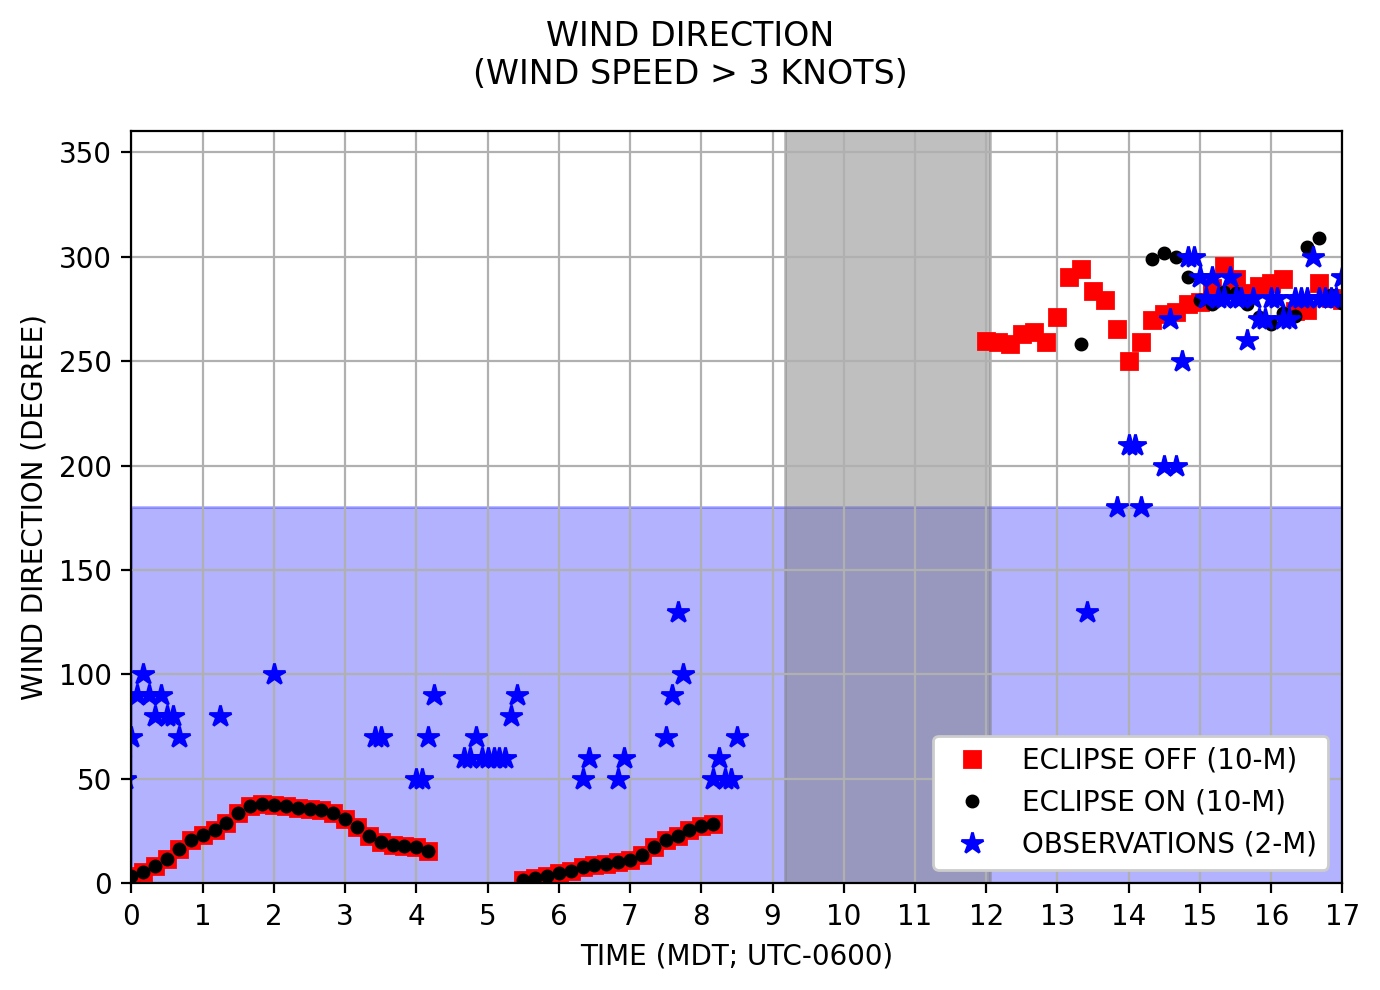

In [20]:
minimum=3
fig = plt.figure(figsize=(7,5),dpi=200)
mask_eclipse = np.where(spd_eclipse_asos*1.94384<minimum)
mask_abv_eclipse = np.where(spd_eclipse_asos*1.94384>=minimum)
mask_no_eclipse = np.where(spd_no_eclipse_asos*1.94384<minimum)
mask_abv_no_eclipse = np.where(spd_no_eclipse_asos*1.94384>=minimum)
mask_obs = np.where(obs_asos_spd<minimum)
mask_abv_obs = np.where(obs_asos_spd>=minimum)
mask_asos = np.where(obs_asos_spd<minimum)
dir_eclipse_asos_slow = np.copy(dir_eclipse_asos)
dir_eclipse_asos[mask_eclipse] = np.nan
dir_eclipse_asos_slow[mask_abv_eclipse] = np.nan
dir_no_eclipse_asos_slow = np.copy(dir_no_eclipse_asos)
dir_no_eclipse_asos[mask_no_eclipse] = np.nan
dir_no_eclipse_asos_slow[mask_abv_no_eclipse] = np.nan
dir_obs_masked = np.copy(obs_asos_dir)
dir_obs_masked[mask_obs] = np.nan
dir_obs_slow = np.copy(obs_asos_dir)
dir_obs_slow[mask_abv_obs] = np.nan

ax=plt.subplot(111)
ax.plot(hours,dir_no_eclipse_asos,'s',markeredgecolor='r',markerfacecolor='r',markersize=6,label='ECLIPSE OFF (10-M)')
ax.plot(hours,dir_eclipse_asos,'.',markeredgecolor='k',markerfacecolor='k',markersize=8,label='ECLIPSE ON (10-M)')
ax.plot(obs_hours,dir_obs_masked,'*',markeredgecolor='b',markerfacecolor='b',markersize=8,label=f'OBSERVATIONS (2-M)')
plt.legend(facecolor='w',framealpha=1,loc="lower right")
ax.fill_between(hours[468:650],0,180,color='b',alpha=0.3)
ax.axvspan(9.18,12.06,0,360,color='gray',alpha=0.5)
plt.ylim(0,360)
plt.xlim(0,17)
ax.set_xticks(range(18))
plt.grid()
fig.suptitle(f'WIND DIRECTION\n(WIND SPEED > {minimum} KNOTS)')
plt.ylabel('WIND DIRECTION (DEGREE)')
plt.xlabel('TIME (MDT; UTC-0600)')
fig.tight_layout()
plt.savefig("wind_dir_10m.png",bbox_inches='tight')

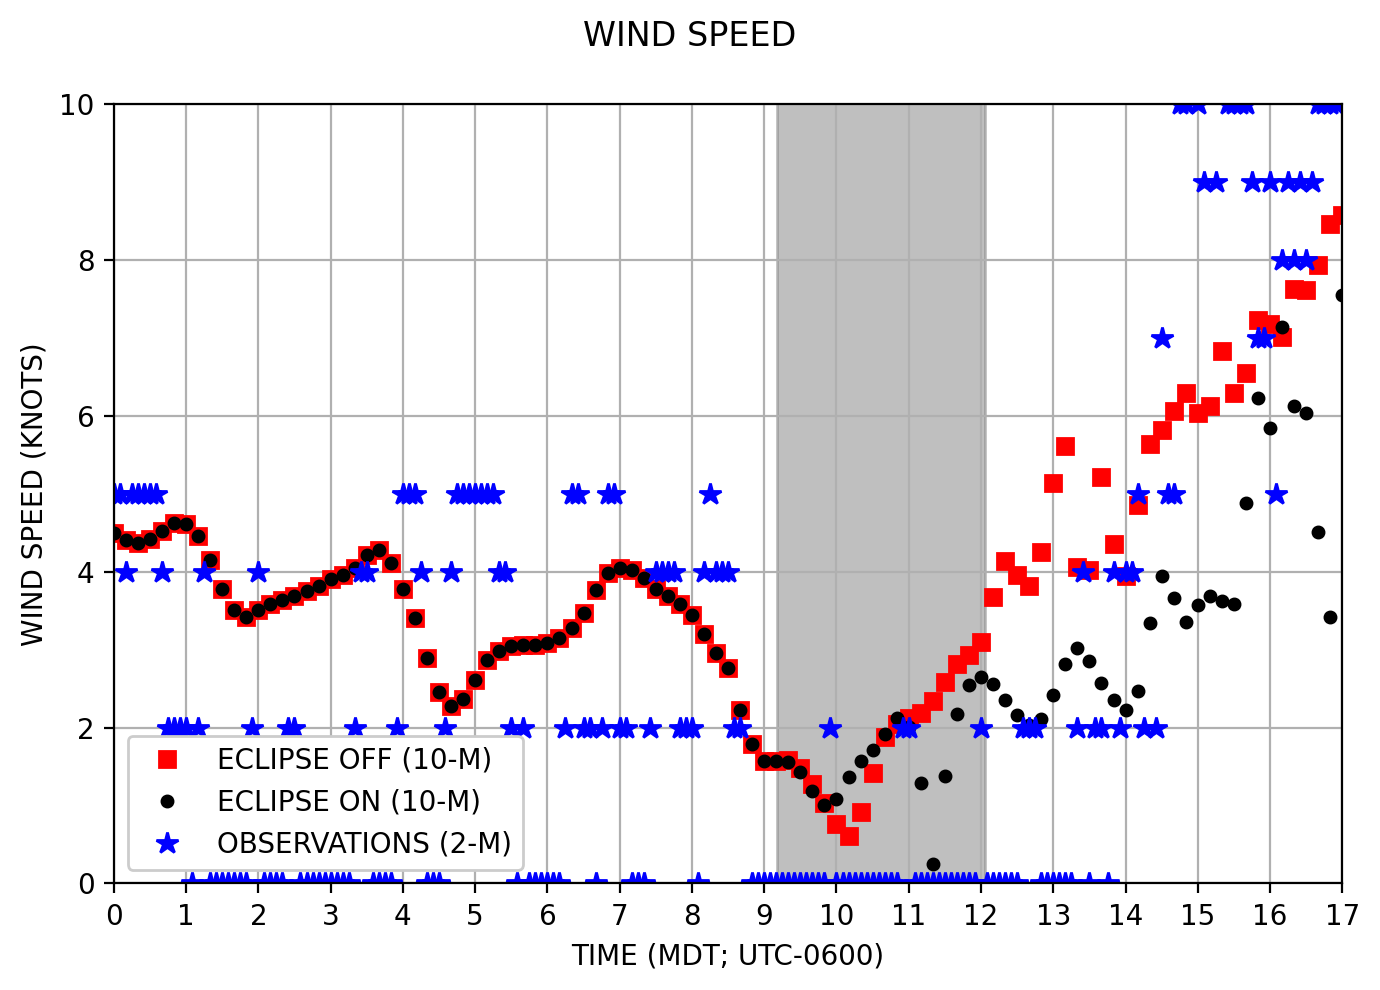

In [14]:
fig = plt.figure(figsize=(7,5),dpi=200)
ws_eclipse_asos = np.copy(spd_eclipse_asos)*1.94384
ws_no_eclipse_asos = np.copy(spd_no_eclipse_asos)*1.94384
ws_obs = np.copy(obs_asos_spd)

ax=plt.subplot(111)
ax.plot(hours[468:650],ws_no_eclipse_asos[468:650],'s',markeredgecolor='r',markerfacecolor='r',markersize=6,label='ECLIPSE OFF (10-M)')
ax.plot(hours[468:650],ws_eclipse_asos[468:650],'.',markeredgecolor='k',markerfacecolor='k',markersize=8,label='ECLIPSE ON (10-M)')
ax.plot(obs_hours,ws_obs,'*',markeredgecolor='b',markerfacecolor='b',markersize=8,label=f'OBSERVATIONS (2-M)')
plt.legend(facecolor='w',framealpha=1,loc="lower left")
ax.axvspan(9.18,12.06,0,360,color='gray',alpha=0.5)
plt.ylim(0,10)
plt.xlim(0,17)
ax.set_xticks(range(18))
plt.grid()
fig.suptitle(f'WIND SPEED')
plt.ylabel('WIND SPEED (KNOTS)')
plt.xlabel('TIME (MDT; UTC-0600)')
fig.tight_layout()
plt.savefig("wind_spd_10m.png",bbox_inches='tight')